
# Base Imports

In [1]:
import importlib
import logging
importlib.reload(logging)
logging.basicConfig(level=logging.INFO)

logging.getLogger("rosetta").setLevel(logging.WARNING)

In [2]:
import toolz
from toolz import first

In [3]:
import pyrosetta.distributed

In [4]:
import tmol.tests.data

In [5]:
import tmol.system.io
import tmol.score
import torch
import tmol.score.ljlk.jit_score_graph
import tmol.score.ljlk.cpp_potential

In [6]:
from tmol.utility.reactive import reactive_attrs, reactive_property

In [7]:
import itertools

In [8]:
import operator
import pandas
import altair

def sum(v):
    return toolz.reduce(operator.add, v)
altair.themes.register("vis", lambda: dict(config={
        "view": {"height": 500, "width": 800},
        "axis": {"labelFontSize": 16, "titleFontSize": 16},
        "legend": {"labelFontSize": 16, "titleFontSize": 16},
        "header": {"labelFontSize": 16, "titleFontSize": 16},
        "title": {"fontSize": 16},
    }))
altair.themes.enable("vis")
altair.data_transformers.enable('default', max_rows=20e3)

pass

# Rosetta Scoring

Benchmark rosetta scoring performance by structure size.

In [9]:
import toolz

In [10]:
decoys = toolz.keyfilter(lambda k: k < 500, tmol.tests.data.structures_bysize())

In [11]:
from tmol.tests.benchmark import subfixture, make_subfixture, make_fixture, stat_frame, stat_profile

torch.set_num_threads(1)

rosetta_score_results = []
scores = {}
profiles = {}

for dsize, d in decoys.items():
    model_name = f"BYSIZE_{dsize}"

    work_pose = d.stripped_pose.pose

    logging.info(dsize)

    fixture = make_fixture(
        "score",
        rosetta_score_results.append,
        nres=len(work_pose.residues),
        natoms=len(d.tmol_coords),
        model=model_name,
        max_time=.25,
        use_cprofile=True,
        
    )

    logging.info("Rosetta")
    atr_rep_sf = pyrosetta.get_score_function()
    for k, v in pyrosetta.rosetta.core.scoring.ScoreType.__members__.items():
        if k not in ("fa_atr", "fa_rep"):
            atr_rep_sf.set_weight(v, 0)

    @subfixture(fixture, impl="rosetta_clear", device="cpu")
    def rosetta_atr_rep_clear():
        work_pose.energies().clear()
        return atr_rep_sf(work_pose)
    
#     move_map = pyrosetta.MoveMap()
#     move_map.set_bb(True)
#     move_map.set_chi(True)
#     move_map.set_jump(True)
    
#     min_map = pyrosetta.rosetta.core.optimization.MinimizerMap()
#     min_map.setup(work_pose, move_map)
#     work_pose.energies().set_use_nblist(work_pose, min_map.domain_map(), False)
#     atr_rep_sf.setup_for_minimizing(work_pose, min_map)
    
#     @subfixture(fixture, impl="rosetta_min", device="cpu")
#     def rosetta_atr_rep_min():
#         return atr_rep_sf(work_pose)
    
    move_map = pyrosetta.MoveMap()
    move_map.set_bb(True)
    
    min_map = pyrosetta.rosetta.core.optimization.MinimizerMap()
    min_map.setup(work_pose, move_map)
    work_pose.energies().set_use_nblist(work_pose, min_map.domain_map(), False)
    atr_rep_sf.setup_for_minimizing(work_pose, min_map)
    
    @subfixture(fixture, impl="rosetta_min", device="cpu")
    def rosetta_atr_rep_min():
        return atr_rep_sf(work_pose)
    
    @reactive_attrs
    class TMolJitLJLK(
        tmol.score.ljlk.jit_score_graph.JitLJLKScoreGraph,
        tmol.score.coordinates.CartesianAtomicCoordinateProvider,
        tmol.score.bonded_atom.BondedAtomScoreGraph,
        tmol.score.device.TorchDevice,
    ):
        pass

    score_graphs = dict(
        tmol_lj_cpu_cpp=TMolJitLJLK.build_for(
            d.tmol_system, requires_grad=False, lj_jit_type="cpp"
        )
    )

    for n, sg in score_graphs.items():
        # Setup graph
        sg.intra_score().total_lj
        
        for block_size, ptype in itertools.product((2, 4, 8, 16), ("blocked",)):
            tmol.score.ljlk.cpp_potential.POTENTIAL_SET = ptype
            tmol.score.ljlk.cpp_potential.BLOCK_SIZE = block_size
            sn= f"{ptype}.{block_size}"
            logging.info(sn)

            gfix = make_subfixture(
                fixture, f".{n}.{sn}", impl=ptype, device=sg.device.type, block_size=block_size,
            )

            @gfix
            def benchmark_score_graph():
                sg.coords = sg.coords
                return sg.intra_score().total_lj

            scores.setdefault(model_name, {})[gfix.name] = benchmark_score_graph

    del score_graphs
    torch.cuda.empty_cache()

    tmol_scores = " ".join(f"{n}: {v}" for n, v in scores[model_name].items())

    logging.info(f"rosetta: {rosetta_atr_rep_min} {rosetta_atr_rep_clear} {tmol_scores}")


INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'extra_options': '-out:levels all:warning'}
INFO:root:100
INFO:root:Rosetta
INFO:tmol.score.ljlk.cpp_potential:_lj_intra_blocked coords.shape: torch.Size([2336, 3]) nops: 469472 block_size: 4 block_pairs.shape: torch.Size([29342, 2])
INFO:root:blocked.2
INFO:tmol.score.ljlk.cpp_potential:_lj_intra_blocked coords.shape: torch.Size([2336, 3]) nops: 310268 block_size: 2 block_pairs.shape: torch.Size([77567, 2])
INFO:tmol.score.ljlk.cpp_potential:_lj_intra_blocked coords.shape: torch.Size([2336, 3]) nops: 310268 block_size: 2 block_pairs.shape: torch.Size([77567, 2])
INFO:tmol.score.ljlk.cpp_potential:_lj_intra_blocked coords.shape: torch.Size([2336, 3]) nops: 310268 block_size: 2 block_pairs.shape: torch.Size([77567, 2])
INFO:tmol.score.ljlk.cpp_potential:_lj_intra_blocked coords.shape: torch.Size([2336, 3]) nops: 310268 block_size: 2 block_pairs.shape: torch.Size([77567, 2])
INFO:tmol.score.ljlk.cpp_potential:_lj

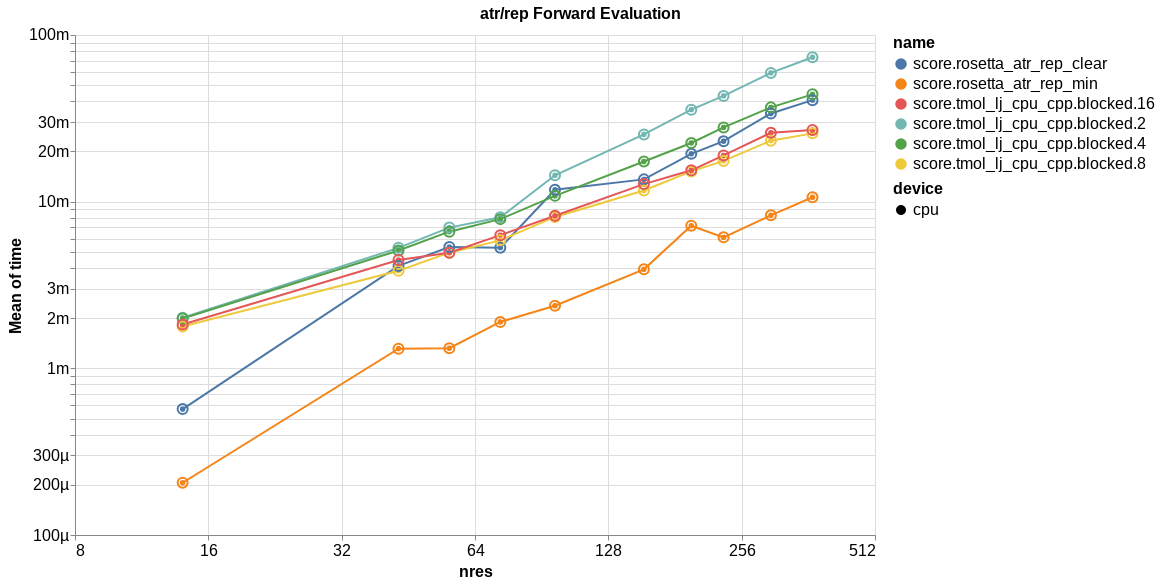

In [15]:
dat = stat_frame(rosetta_score_results)
dat = pandas.concat(
    (
        dat,
        pandas.merge(
            dat,
            dat.query("name == 'score.rosetta_atr_rep'")
            .groupby("model")
            .time.mean()
            .rename("rosetta_mean")
            .to_frame(),
            left_on="model",
            right_index=True,
        )
        .eval("time / rosetta_mean")
        .rename("rosetta_relative"),
    ),
    axis=1,
)

encoding = dict(
    x=altair.X(
        "nres", axis=altair.Axis(format="s"), scale=altair.Scale(type="log", base=2)
    ),
    y=altair.Y(
        "mean(time)",
        scale=altair.Scale(type="log", base=10),
        axis=altair.Axis(format="s"),
    ),
    color="name", 
    shape="device",
)

sum(
    (
        altair.Chart(dat, title="atr/rep Forward Evaluation")
        .mark_line()
        .encode(**encoding),
        altair.Chart(dat).mark_point(size=100).encode(**encoding)
    )
).configure_legend(labelLimit=0)

/scratch/USERS/fordas/envs/tmol/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
/scratch/USERS/fordas/envs/tmol/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


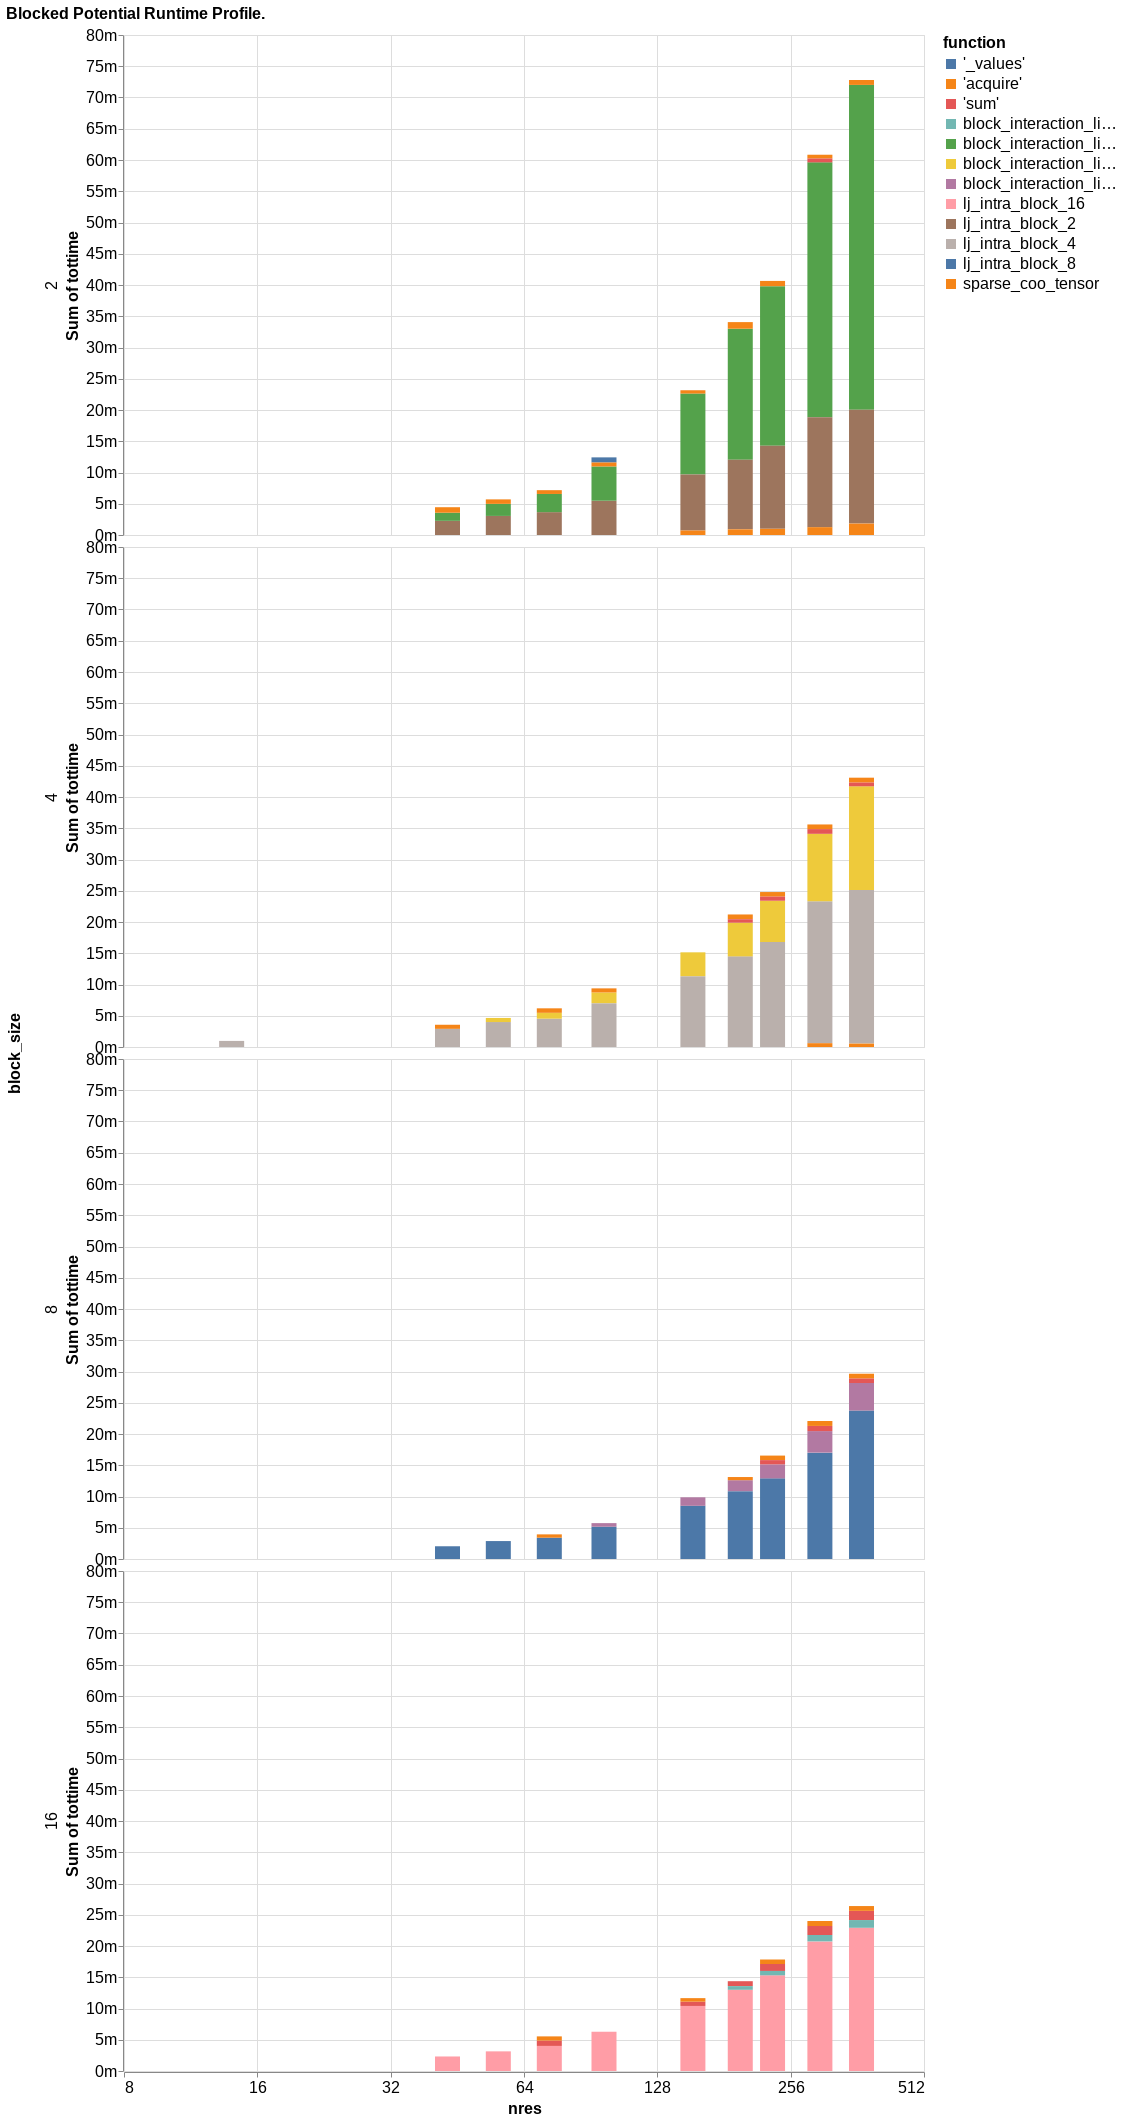

In [16]:
pdat = stat_profile(rosetta_score_results)
pdat = pdat[~pdat.impl.str.contains("rosetta")]
rdat = pdat.query("tottime > 500e-6 and fractime > 1e-3")
rdat["function"] = (
    rdat.function_name.str.extract("method (['\.\w]*)")
    .where(lambda v: ~pandas.isna(v), rdat.function_name)
    .map(lambda v: v.split(".")[-1])
)

encoding = dict(
    x=altair.X(
        "nres", axis=altair.Axis(format="s"), scale=altair.Scale(type="log", base=2)
    ),
    y=altair.Y("sum(tottime)", axis=altair.Axis(format="s")),
    color="function",
    row="block_size",
)

c = (altair.Chart(rdat).mark_bar().encode(**encoding)).configure(
    bar={"continuousBandSize": 25}
)
c.title = "Blocked Potential Runtime Profile."
c


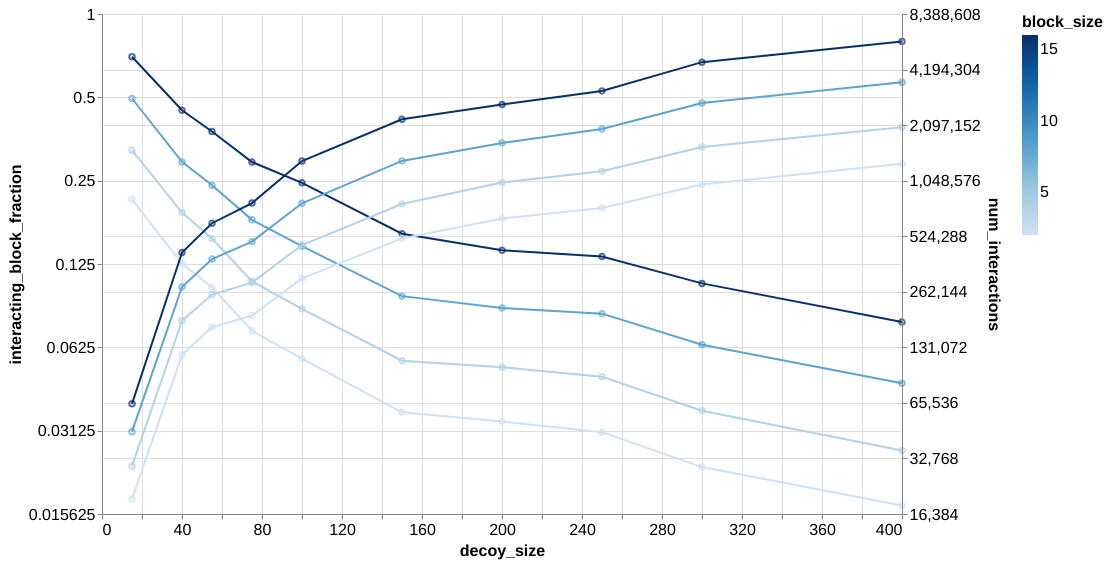

In [21]:
rec = []
for dsize, d in decoys.items():
    for bsize in (2, 4, 8, 16):
        bil = getattr(tmol.score.ljlk.cpp_potential.cpu, "block_interaction_lists_%i" % bsize)
        bit = bil(d.tmol_coords, 6.0)
        bit_frac = float(bit.shape[0]) / (d.tmol_coords.shape[0] / bsize) ** 2
        rec.append(dict(decoy_size=dsize, num_interactions = bit.shape[0] * bsize ** 2, interacting_block_fraction=bit_frac, block_size=bsize))

c = altair.Chart(pandas.DataFrame.from_records(rec)).encode(x="decoy_size")

encoding = dict(y=altair.Y("interacting_block_fraction", scale=altair.Scale(type="log", base=2)), color="block_size", )
bf = sum([c.mark_line().encode(**encoding), c.mark_point().encode(**encoding)])

encoding = dict(x="decoy_size", y=altair.Y("num_interactions", scale=altair.Scale(type="log", base=2)), color="block_size", )
ni = sum([c.mark_line().encode(**encoding), c.mark_point().encode(**encoding)])

altair.layer(bf, ni).resolve_scale(y="independent")

In [28]:
display((
    dat.query("name=='score.rosetta_atr_rep_clear'")
    .groupby("nres")[["time"]]
    .describe().reorder_levels((1, 0), axis=1)[["mean", "max", "std"]]
))

display((dat
    .groupby(("nres", "name"))[["rosetta_relative", "time"]]
    .describe()
    .reorder_levels((1, 0), axis=1)["mean"]
    .xs("score.tmol_lj_cpu_cpp.blocked.8", level=1)
    .eval("fold_acceleration = rosetta_relative ** -1")
))

,mean,max,std
,time,time,time
nres,,,
14,0.000570,0.000757,0.000025
43,0.004116,0.004351,0.000046
56,0.005338,0.005959,0.000698
73,0.005299,0.007172,0.000400
97,0.011781,0.012303,0.001168
154,0.013608,0.013769,0.000089
197,0.019373,0.019731,0.000165
233,0.023051,0.023284,0.000139


,rosetta_relative,time,fold_acceleration
nres,,,
14,NaN,0.001781,NaN
43,NaN,0.003847,NaN
56,NaN,0.004943,NaN
73,NaN,0.005859,NaN
97,NaN,0.008099,NaN
154,NaN,0.011665,NaN
197,NaN,0.015194,NaN
233,NaN,0.017555,NaN
298,NaN,0.023235,NaN
